In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("McGill-NLP/feedbackQA")

Found cached dataset feedback_qa (/home/raja/.cache/huggingface/datasets/McGill-NLP___feedback_qa/plain_text/1.0.0/20c8f938f417c88303bb7041cea9554c1d14667686d7d7c5dda83dd4f39e5dc4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
rating_scores = {'Excellent':3 , 'Acceptable':2 , 'Could be Improved':1, 'Bad': -1}

def process_df(df):
    df['list_feedback'] = df['feedback'].apply(lambda x: [ r + "___" + e for r,e in zip(x['rating'],x['explanation']) ])
    df['sampled_feedback'] = df['list_feedback'].apply(lambda x: np.random.choice(x).split("___") )
    df['rating_score'] = df['sampled_feedback'].apply(lambda x: rating_scores[x[0]])
    df['rating'] = df['sampled_feedback'].apply(lambda x: x[0])
    df['explanation'] = df['sampled_feedback'].apply(lambda x: x[1])
    return df

In [3]:
train_df = process_df(pd.DataFrame(dataset['train']))
val_df = process_df(pd.DataFrame(dataset['validation']))
test_df = process_df(pd.DataFrame(dataset['test']))

In [4]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

# Load model from HuggingFace Hub
bart_chkpt = 'facebook/bart-large'
tokenizer = AutoTokenizer.from_pretrained(bart_chkpt)

In [5]:
train_df.head()

,question,answer,feedback,list_feedback,sampled_feedback,rating_score,rating,explanation
0,How do I get help finding a job?,Coronavirus (COVID-19) information for job see...,"{'rating': ['Excellent', 'Could be Improved'],...",[Excellent___Has a link to detailed informatio...,"[Excellent, Has a link to detailed information...",3,Excellent,Has a link to detailed information about gover...
1,How do I get help finding a job?,Coronavirus (COVID-19) information for job see...,"{'rating': ['Excellent', 'Excellent'], 'explan...",[Excellent___A link to a job search website is...,"[Excellent, A link to a job search website is ...",3,Excellent,"A link to a job search website is included, as..."
2,How do I get help finding a job?,Coronavirus (COVID-19) information and support...,"{'rating': ['Bad', 'Acceptable'], 'explanation...",[Bad___Talks about tax credits for businesses ...,"[Acceptable, This answer discusses the Employm...",2,Acceptable,"This answer discusses the Employment Fund, whi..."
3,If I am in Australia on a worker holiday marke...,Frequently Asked Questions\nWorking holiday ma...,"{'rating': ['Could be Improved', 'Acceptable']...",[Could be Improved___Answer is about Working H...,"[Acceptable, Answer is rather cut and dry but ...",2,Acceptable,Answer is rather cut and dry but is also a lit...
4,If I am in Australia on a worker holiday marke...,Frequently Asked Questions\nCOVID-19 Pandemic ...,"{'rating': ['Bad', 'Could be Improved'], 'expl...",[Bad___Discusses pandemic visas. Doesn't menti...,"[Bad, Discusses pandemic visas. Doesn't mentio...",-1,Bad,Discusses pandemic visas. Doesn't mention the ...


In [6]:
tokenizer('Hello, how are you doing?'+ f" {tokenizer.eos_token} " + "Hemlooooo",add_special_tokens=True,return_tensors='pt', return_length=1)

{'input_ids': tensor([[    0, 31414,     6,   141,    32,    47,   608,   116,  1437,     2,
         10869,   462, 40386,   139,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'length': tensor([15])}

In [39]:
import tqdm

class feedback_QA_dataset(Dataset):
    
    def __init__(self,df,max_length=300):
        self.df = df
        self.max_len = max_length
        self.data = []
        
        for i in tqdm.tqdm(range(len(self.df)),desc='vectorizing..'):
            
            d = {}
            
            tok_input = tokenizer(('Question:' + self.df.iloc[i]['question'] + ' Answer: ' + self.df.iloc[i]['answer']).replace("\n"," "),
                                  return_token_type_ids=True, 
                                  add_special_tokens=True, 
                                  return_length=True,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation='only_first',
                                  return_tensors='pt')

            feedback = self.df.iloc[i]['explanation']

            tok_feedback = tokenizer(feedback, 
                                     return_token_type_ids=True,
                                     add_special_tokens=False,
                                     return_length=True,
                                     max_length=300, 
                                     padding='max_length', 
                                     truncation='only_first',
                                     return_tensors='pt')

            d['input'] = tok_input['input_ids'].squeeze(0)
            d['input_attn'] = tok_input['attention_mask'].squeeze(0)
            # d['feedback'] = tok_feedback['input_ids']
            # d['feedback_attn'] = tok_feedback['attention_mask']
            
            labels = tok_feedback['input_ids'].squeeze(0)#[:,1:]#.clone()
            labels[labels==tokenizer.pad_token_id] = -100
            d['labels'] = labels
            
            d['feedback_len'] = tok_feedback['length'][0]

            self.data.append(d)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]

In [40]:
# train_dataset = feedback_QA_dataset(train_df)
# valid_dataset = feedback_QA_dataset(val_df)
test_dataset = feedback_QA_dataset(test_df)

vectorizing..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1995/1995 [00:03<00:00, 514.70it/s]


In [41]:
# train_DL = DataLoader(train_dataset,batch_size=5,shuffle=True)
# valid_DL = DataLoader(valid_dataset,batch_size=5,shuffle=True)
test_DL = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [32]:
for b in test_DL:
    print(b['input'].shape , b['feedback'].shape, b['feedback_attn'].shape)
    break

torch.Size([1, 1, 1024]) torch.Size([1, 1, 500]) torch.Size([1, 1, 500])


from transformers import BartForConditionalGeneration

device = 'cuda:0'

bart_model = BartForConditionalGeneration.from_pretrained(bart_chkpt).to(device)

with torch.no_grad():
    for b in train_DL:
        output = bart_model(input_ids=b['input'].to(device),
                            decoder_input_ids=b['feedback'].squeeze(1)[:,:-1].to(device),)
                            #labels=b['feedback'].squeeze(1)[:,1:].to(device))
        print(tokenizer.decode(b['input'][:,0][0],skip_special_tokens=True),"\n\n")
        print(tokenizer.decode(b['feedback'][:,0,:-1][0]))
        print(tokenizer.decode(b['feedback'][:,0,1:][0]))
        print(output.logits.shape)
        break

del bart_model

In [33]:
def train(generator,train_dl,valid_dl,epochs,optimizer,PATIENCE=20,save_dir=None):

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    
    generator.train()
    
    loss_acc = 0
    num_batches = 0
    total_steps = 0
    best_valid_loss = np.inf
    patience = PATIENCE
    
    train_loss_arr,valid_loss_arr = [],[]
    
    optimizer.zero_grad()
    generator.zero_grad()
    
    for E in range(epochs):
        
        for b in train_dl:
            
            y = generator(input_ids=b['input'].to(device),
                          decoder_input_ids=b['feedback'].squeeze(1)[:,:-1].to(device),
                          decoder_attention_mask=b['feedback_attn'].squeeze(1)[:,:-1].to(device))
            loss = F.cross_entropy(y.logits.permute(0,2,1), b['feedback'].squeeze(1)[:,1:].to(device), ignore_index=tokenizer.pad_token_id)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_acc += loss.item()
            num_batches += 1
            total_steps += 1
            
            train_loss_arr.append(loss_acc/num_batches)
            
            if total_steps%100==0:
                print("Epoch:",E,"\t","Steps taken:",total_steps,"\tLoss:",loss_acc/num_batches)
            
        #print("Epoch:",E,"\t","Steps taken:",total_steps,"\tLoss:",loss_acc/num_batches)
        
        torch.save({'model_state':generator.state_dict(),
                    'optimizer':optimizer.state_dict(),
                    'epoch':E},
                    f"{save_dir}/Epoch_{E}_model_chkpt.pth.tar")
        
        valid_loss = validate(generator,valid_dl)
        valid_loss_arr.append(valid_loss/len(valid_dl))
        
        if valid_loss<best_valid_loss:
            best_valid_loss = valid_loss
            patience = PATIENCE
            
            torch.save({'model_state':generator.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'epoch':E},
                        f"{save_dir}/best_model_chkpt.pth.tar")
        else:
            patience -= 1
            print(f"REDUCING PATIENCE...{patience}")

        if patience<=0:
            print("RUNNING OUT OF PATIENCE... TERMINATING")
            break
    
    
    return train_loss_arr,valid_loss_arr
                

In [34]:
def validate(generator,valid_dl):
    
    generator.eval()
    valid_loss = 0
    with torch.no_grad():
        for b in valid_dl:
            y = generator(input_ids=b['input'].to(device),
                          decoder_input_ids=b['feedback'].squeeze(1)[:,:-1].to(device),
                          decoder_attention_mask=b['feedback_attn'].squeeze(1)[:,:-1].to(device))
            loss = F.cross_entropy(y.logits.permute(0,2,1), b['feedback'].squeeze(1)[:,1:].to(device), ignore_index=tokenizer.pad_token_id)
            valid_loss += loss.item()
            
    print("Validation Loss:",valid_loss)
    return valid_loss

In [42]:
import os

from transformers import BartForConditionalGeneration

device = 'cuda:1'

generator = BartForConditionalGeneration.from_pretrained(bart_chkpt).to(device)

# optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-5)

# save_dir = 'GenFB_BART_large_chkpts_1'
# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)

# train_loss,valid_loss = train(generator,train_DL,valid_DL,50,optimizer,PATIENCE=5,save_dir=save_dir)

In [ ]:
import json

with open('train_loss.json','w') as f:
    json.dump(train_loss,f)

with open('valid_loss.json','w') as f:
    json.dump(valid_loss,f)

In [ ]:
train_loss_ds = np.array(train_loss)[np.round(np.linspace(0, len(train_loss) - 1, len(valid_loss))).astype(int)]
loss_df = pd.DataFrame({'train_loss':train_loss_ds , 'valid_loss':valid_loss})

In [ ]:
from plotly import express as px
px.line(loss_df,y=['train_loss','valid_loss'])

In [164]:
generator.load_state_dict(torch.load('GenFB_BART_large_chkpts_4/best_model_chkpt.pth.tar')['model_state'])

<All keys matched successfully>

In [165]:
i = 0
for b in test_DL:
    out = generator.generate(inputs=b['input'].to(device),min_length=500)#, do_sample=True,decoder_start_token_id=tokenizer.eos_token_id)
    print(tokenizer.decode(b['input'][0],skip_special_tokens=True))
    print(tokenizer.decode(b['labels'][b['labels'].ne(-100)],skip_special_tokens=True))
    print(tokenizer.decode(out[0]))
    print("--------------------------------------------------------")
    i+=1
    if i>10:
        break

Question:What are my options if I can not support myself on a WHM visa? Answer: Frequently Asked Questions COVID-19 Pandemic - Australian Government Endorsed Event (AGEE) stream of the Temporary Activity (subclass 408) visa Frequently Asked Questions When can I apply for the COVID-19 Pandemic event visa? You should only apply for this visa is you are unable to depart Australia, your temporary visa expires in less than 28 days (or did not expire more than 28 days ago) and you have no other visa options available to you.
This only talks about Visa application, it fails to talk about the topic
</s><s>Summary: This answer is irrelevant to the question. This answer does not provide any information</s>
--------------------------------------------------------
Question:I was a working Holiday Maker but lost my job; what should I do? Answer: Frequently Asked Questions COVID-19 Pandemic - Australian Government Endorsed Event (AGEE) stream of the Temporary Activity (subclass 408) visa Frequently 

In [153]:
i = 0

generator.eval()

x,y,mat = None,None,None

with torch.no_grad():
    for b in test_DL:
        gen = generator.generate(inputs=b['input'].to(device),min_length=500)
        out = generator(input_ids=b['input'].to(device),attention_mask=b['input_attn'].to(device),decoder_input_ids=gen,output_attentions=True)#, do_sample=True,decoder_start_token_id=tokenizer.eos_token_id)
        ca = out.cross_attentions
        ea = out.encoder_attentions
        print(gen.shape, b['input'].shape, len(ca), ca[0][0,:,:,:].mean(dim=0),ea[0].shape)
        x = tokenizer.tokenize(tokenizer.decode(gen[0]))
        y = tokenizer.tokenize(tokenizer.decode(b['input'][0]))
        mat = ca[-1][0,:,:,:].mean(dim=0).cpu().numpy()
        print("--------------------------------------------------------")
        i+=1
        if i>1:
            break

torch.Size([1, 20]) torch.Size([1, 300]) 12 tensor([[0.0931, 0.0044, 0.0084,  ..., 0.0000, 0.0000, 0.0000],
        [0.0881, 0.0077, 0.0084,  ..., 0.0000, 0.0000, 0.0000],
        [0.1037, 0.0198, 0.0231,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1189, 0.0030, 0.0038,  ..., 0.0000, 0.0000, 0.0000],
        [0.2431, 0.0031, 0.0040,  ..., 0.0000, 0.0000, 0.0000],
        [0.0988, 0.0103, 0.0136,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:1') torch.Size([1, 16, 300, 300])
--------------------------------------------------------
torch.Size([1, 20]) torch.Size([1, 300]) 12 tensor([[0.0917, 0.0046, 0.0102,  ..., 0.0000, 0.0000, 0.0000],
        [0.0872, 0.0081, 0.0105,  ..., 0.0000, 0.0000, 0.0000],
        [0.1023, 0.0198, 0.0260,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1116, 0.0032, 0.0030,  ..., 0.0000, 0.0000, 0.0000],
        [0.1102, 0.0035, 0.0045,  ..., 0.0000, 0.0000, 0.0000],
        [0.0960, 0.0105, 0.0135,  ..., 0.0000, 0.0000, 0.0000]],
     

In [113]:
x,y,mat

(['</s>',
  '<s>',
  'This',
  'Ġanswer',
  'Ġis',
  'Ġirrelevant',
  'Ġto',
  'Ġthe',
  'Ġquestion',
  '.',
  'ĠThis',
  'Ġanswer',
  'Ġis',
  'Ġabout',
  'Ġapplying',
  'Ġfor',
  'Ġa',
  'Ġvisa',
  'Ġand',
  '</s>'],
 ['<s>',
  'Question',
  ':',
  'I',
  'Ġwas',
  'Ġa',
  'Ġworking',
  'ĠHoliday',
  'ĠMaker',
  'Ġbut',
  'Ġlost',
  'Ġmy',
  'Ġjob',
  ';',
  'Ġwhat',
  'Ġshould',
  'ĠI',
  'Ġdo',
  '?',
  'ĠAnswer',
  ':',
  'ĠFrequ',
  'ently',
  'ĠAsked',
  'ĠQuestions',
  'ĠCO',
  'VID',
  '-',
  '19',
  'ĠPand',
  'emic',
  'Ġ-',
  'ĠAustralian',
  'ĠGovernment',
  'ĠEnd',
  'ors',
  'ed',
  'ĠEvent',
  'Ġ(',
  'AG',
  'EE',
  ')',
  'Ġstream',
  'Ġof',
  'Ġthe',
  'ĠTemporary',
  'ĠActivity',
  'Ġ(',
  'sub',
  'class',
  'Ġ408',
  ')',
  'Ġvisa',
  'ĠFrequ',
  'ently',
  'ĠAsked',
  'ĠQuestions',
  'ĠWhen',
  'Ġcan',
  'ĠI',
  'Ġapply',
  'Ġfor',
  'Ġthe',
  'ĠCO',
  'VID',
  '-',
  '19',
  'ĠPand',
  'emic',
  'Ġevent',
  'Ġvisa',
  '?',
  'ĠYou',
  'Ġshould',
  'Ġonly',
  'Ġa

In [122]:
y[19:41]

['ĠAnswer',
 ':',
 'ĠFrequ',
 'ently',
 'ĠAsked',
 'ĠQuestions',
 'ĠCO',
 'VID',
 '-',
 '19',
 'ĠPand',
 'emic',
 'Ġ-',
 'ĠAustralian',
 'ĠGovernment',
 'ĠEnd',
 'ors',
 'ed',
 'ĠEvent',
 'Ġ(',
 'AG',
 'EE']

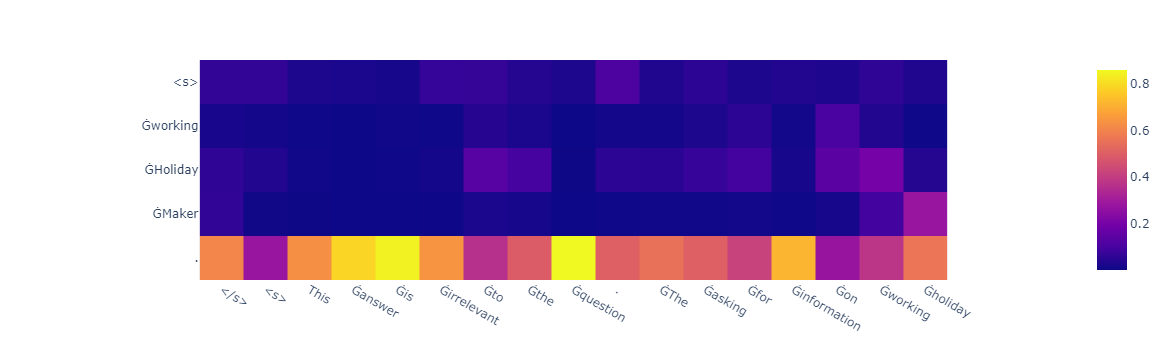

In [151]:
from plotly import express as px
fig = px.imshow(mat[:,(mat>0.1).any(axis=0)].transpose(),x=x,
                y=np.array(y)[np.where((mat>0.1).any(axis=0))])#, width=10,height=10)
# fig.update_xaxes(side="top")
fig.show()

In [146]:
mat[:,(mat>0.1).any(axis=0)].shape

(20, 5)

In [148]:
np.where((mat>0.1).any(axis=0))

(array([  0,   6,   7,   8, 117]),)

In [150]:
np.array(y)[np.where((mat>0.1).any(axis=0))]

array(['<s>', 'Ġworking', 'ĠHoliday', 'ĠMaker', '.'], dtype='<U11')